<a href="https://colab.research.google.com/github/arthurnicolas59/BloodCellDec22---DataScientest/blob/Ludo/5_Cr%C3%A9ation_des_images_masqu%C3%A9es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Connexion au Drive, activation du GPU**


In [1]:
### Import des modules nécessaires pour l'ensemble du travail

import numpy as np
import os
import glob
import cv2
from keras import callbacks
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

**Activation du GPU**



In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Default GPU Device:/device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **2. Création des 17000 images masquées**

**1. Import des images originales et des masques**

In [ ]:
### import des images originales et des masques

# image originale
!unzip 'drive/MyDrive/Datascientest/PBC_dataset_normal_DIB.zip'

#suppression d'une image corrompue
import os

os.remove('/content/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg')

# mask
!unzip 'drive/MyDrive/Datascientest/masques_Unet_17000_2208.zip'

**2. création d'un dataframe 'df_mask' répertoriant les accès aux images ainsi qu'à leur masques et leur label**

In [5]:
import glob
import pandas as pd

# Trouver tous les chemins vers les fichiers qui finissent par .png
liste_mask = glob.glob('/content/masques/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_mask = list(map(lambda x : [x,
                                  x.split('/')[4].split('_')[0],
                                  '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg'],
                       liste_mask))

# Créer un DataFrame pandas
df_mask = pd.DataFrame(liste_mask, columns=['maskpath', 'nameLabel','filepath'])
df_mask=df_mask.replace(['SNE','BNE'],'NEUTROPHIL')
df_mask=df_mask.replace(['MY','MMY','PMY'],'IG')
df_mask.sort_values('maskpath')
df_mask

,maskpath,nameLabel,filepath
0,/content/masques/erythroblast/ERB_313180_mask.png,ERB,/content/PBC_dataset_normal_DIB/erythroblast/E...
1,/content/masques/erythroblast/ERB_448264_mask.png,ERB,/content/PBC_dataset_normal_DIB/erythroblast/E...
2,/content/masques/erythroblast/ERB_624420_mask.png,ERB,/content/PBC_dataset_normal_DIB/erythroblast/E...
3,/content/masques/erythroblast/ERB_940863_mask.png,ERB,/content/PBC_dataset_normal_DIB/erythroblast/E...
4,/content/masques/erythroblast/ERB_659279_mask.png,ERB,/content/PBC_dataset_normal_DIB/erythroblast/E...
...,...,...,...
17087,/content/masques/platelet/PLATELET_190724_mask...,PLATELET,/content/PBC_dataset_normal_DIB/platelet/PLATE...
17088,/content/masques/platelet/PLATELET_435977_mask...,PLATELET,/content/PBC_dataset_normal_DIB/platelet/PLATE...
17089,/content/masques/platelet/PLATELET_788913_mask...,PLATELET,/content/PBC_dataset_normal_DIB/platelet/PLATE...
17090,/content/masques/platelet/PLATELET_430818_mask...,PLATELET,/content/PBC_dataset_normal_DIB/platelet/PLATE...


**3. création d'un répertoire 'fusion' et de 8 sous répertoires pour l'enregistrement des images masquées**

In [6]:
# Chemin du répertoire principal de Google Drive
main_dir_masques='/content/'

# Nom du sous-dossier à créer
subfolder_name = 'fusion'

# Chemin complet du sous-dossier à créer
subfolder_path = os.path.join(main_dir_masques, subfolder_name)

# Vérifier si le sous-dossier existe déjà
if not os.path.exists(subfolder_path):
    # Créer le sous-dossier
    os.makedirs(subfolder_path)
    print("Le sous-dossier '{}' a été créé avec succès.".format(subfolder_name))
else:
    print("Le sous-dossier '{}' existe déjà.".format(subfolder_name))

main_dir='/content/PBC_dataset_normal_DIB'

liste_dossier=[]
for folder_idx, folder in enumerate(os.listdir(path=main_dir)):
  liste_dossier.append(folder)

print(liste_dossier)

for folder_name in liste_dossier:
  group_path=os.path.join(subfolder_path,folder_name)

  # Vérifier si le sous-dossier existe déjà
  if not os.path.exists(group_path):
    # Créer le sous-dossier
    os.makedirs(group_path)
    print("Le sous-dossier '{}' a été créé avec succès.".format(folder_name))
  else:
    print("Le sous-dossier '{}' existe déjà.".format(folder_name))

Le sous-dossier 'fusion' a été créé avec succès.
['erythroblast', 'neutrophil', 'eosinophil', 'basophil', 'lymphocyte', 'monocyte', 'ig', 'platelet']
Le sous-dossier 'erythroblast' a été créé avec succès.
Le sous-dossier 'neutrophil' a été créé avec succès.
Le sous-dossier 'eosinophil' a été créé avec succès.
Le sous-dossier 'basophil' a été créé avec succès.
Le sous-dossier 'lymphocyte' a été créé avec succès.
Le sous-dossier 'monocyte' a été créé avec succès.
Le sous-dossier 'ig' a été créé avec succès.
Le sous-dossier 'platelet' a été créé avec succès.


**4. Création et enregistrement des images masquées**

In [ ]:
from tqdm import tqdm
import numpy as np
import os
import cv2
from PIL import Image
import imageio
from skimage import filters
import time

df_fusion=df_mask

# Définition d'une liste contenant les différents labels

liste_label =df_fusion.nameLabel.unique()

# Assurez-vous que le répertoire de sortie existe

for label in liste_label:
    FUSION_DF = df_fusion[df_fusion['nameLabel'] == label]
    IMAGE_PATH = FUSION_DF['filepath'].values
    MASK_PATH=FUSION_DF['maskpath'].values

    for i in tqdm(range(len(FUSION_DF))):
        # Lire l'image
        image = cv2.imread(IMAGE_PATH[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(MASK_PATH[i], cv2.IMREAD_UNCHANGED)

        desired_shape=(224,224)

        image = cv2.resize(image, desired_shape)
        mask = cv2.resize(mask, desired_shape)

        result = (image * mask[:, :, None]).astype(image.dtype)

        # Chemin du dossier où vous souhaitez enregistrer l'image
        output_folder = '/content/fusion/' + IMAGE_PATH[i].split('/')[3]

        # Nom du fichier de sortie
        output_filename = str(FUSION_DF['filepath'].iloc[i]).split('/')[4].split('.')[0]+'_fusion.png'

        # Chemin complet du fichier de sortie
        output_path = output_folder+'/'+output_filename

        # Enregistrer l'image fusionnée

        cv2.imwrite(output_path, result)

100%|██████████| 1214/1214 [00:03<00:00, 317.42it/s]


**5. Vérification du chargement et de l'affichage des masques créés**

100%|██████████| 2/2 [00:00<00:00, 22.57it/s]


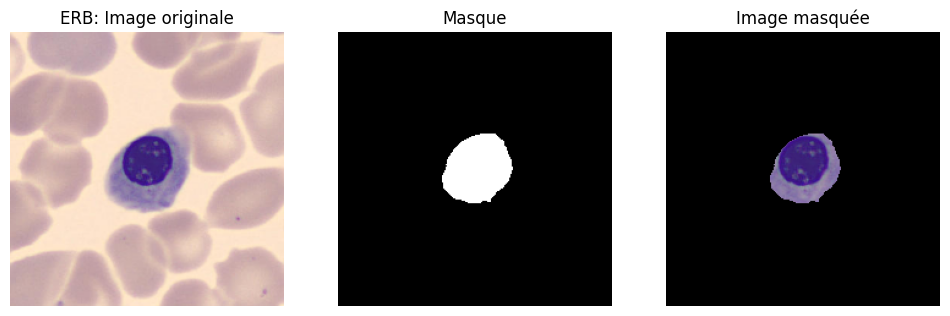

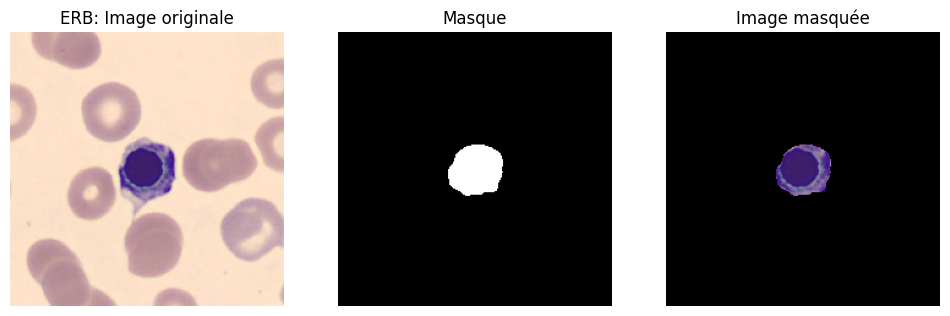

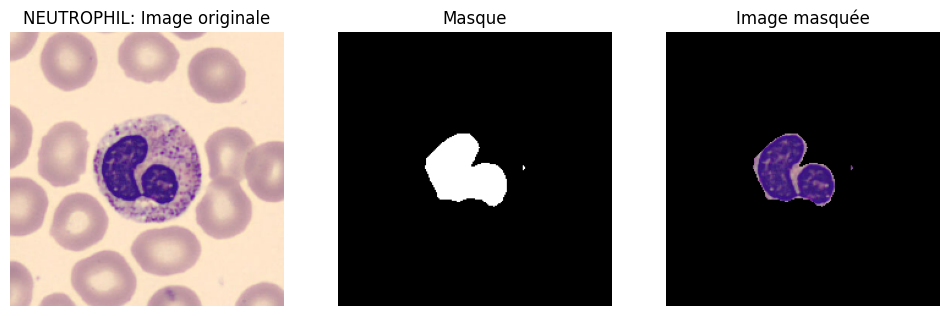

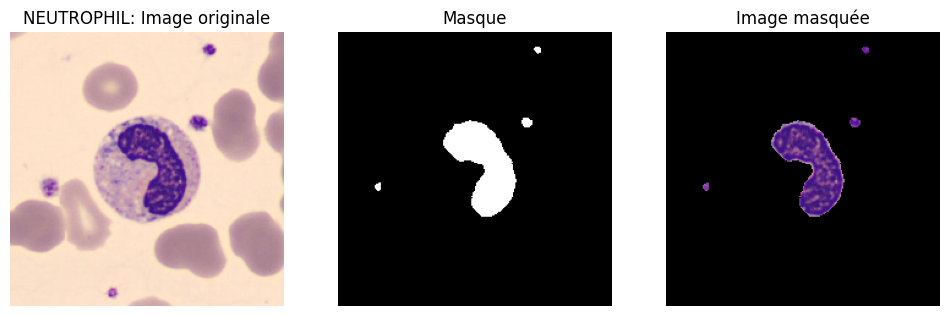

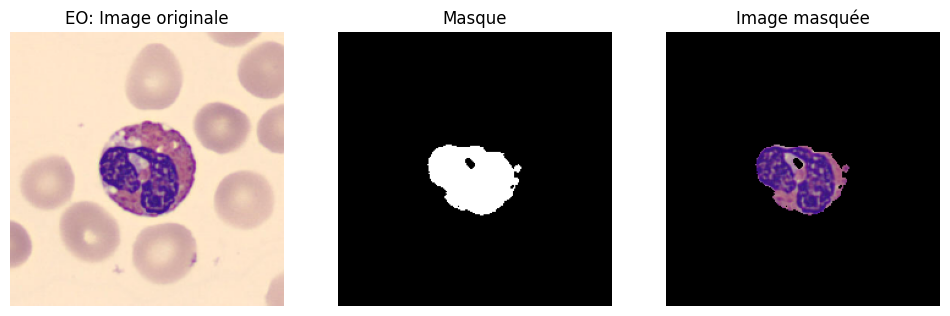

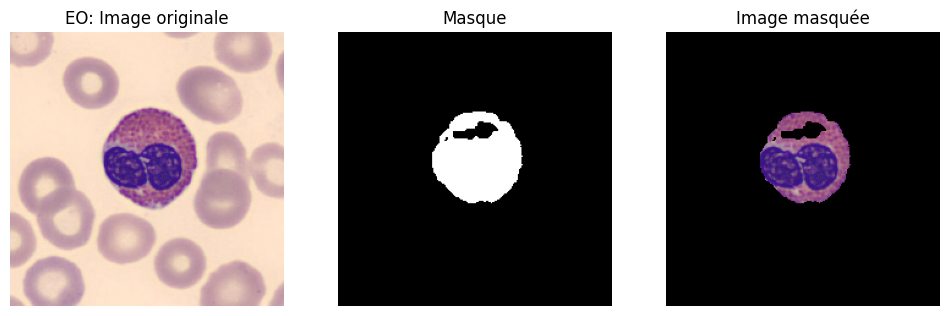

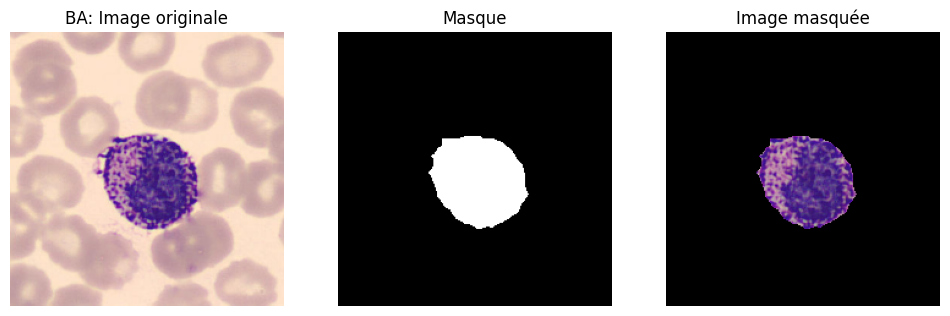

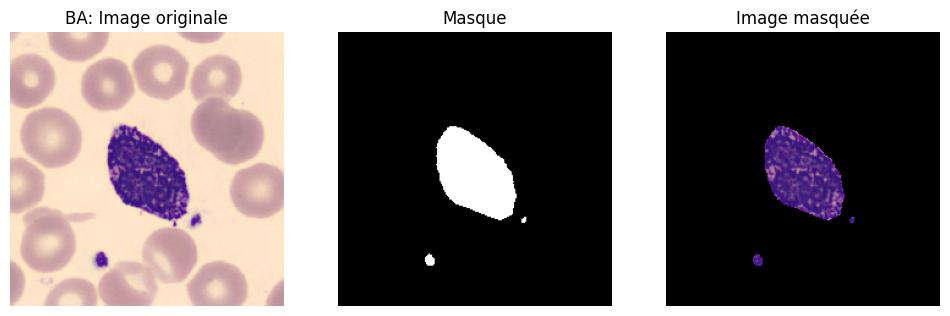

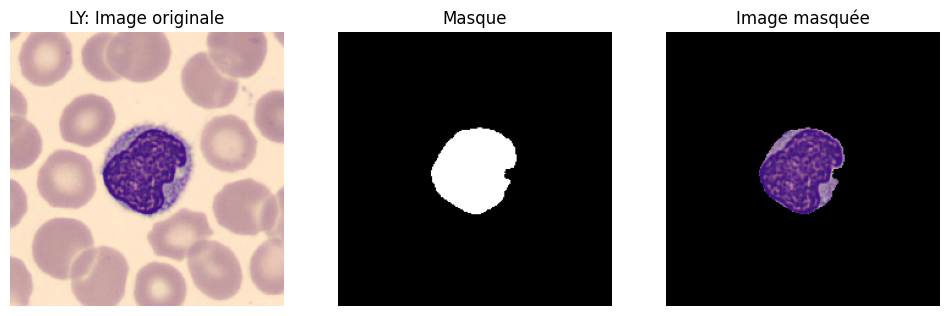

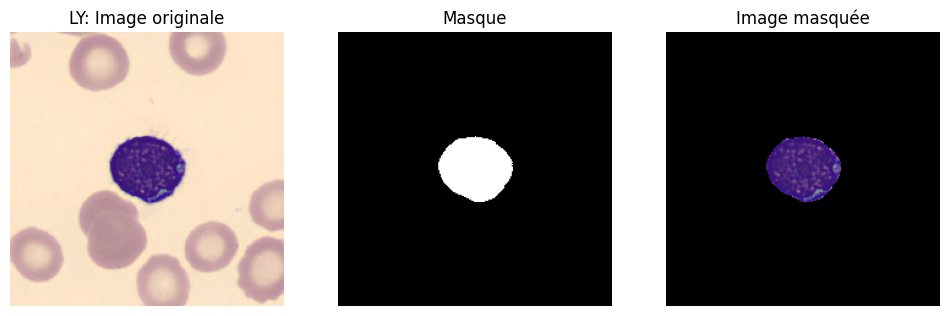

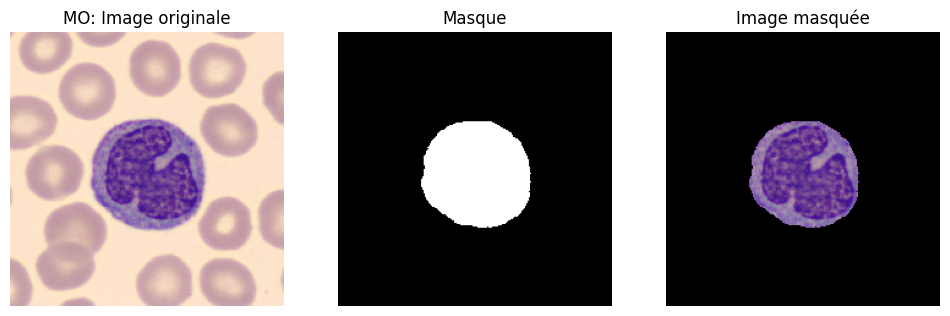

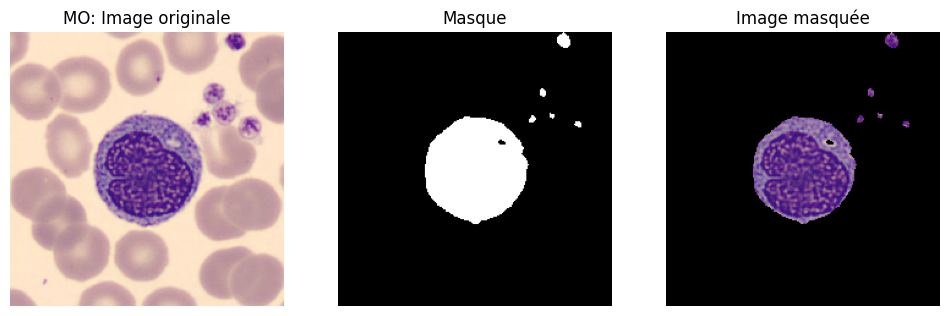

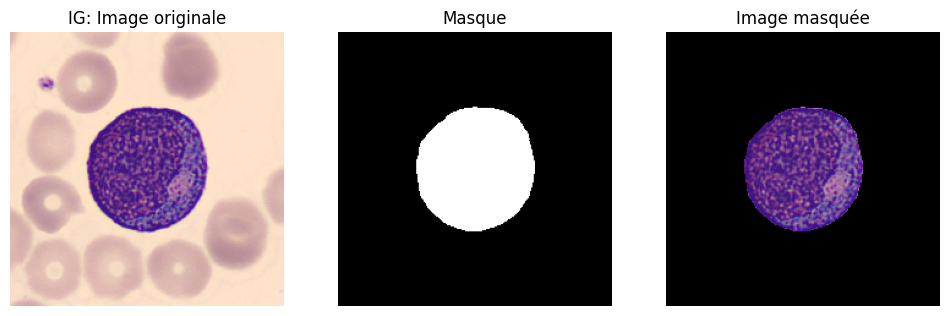

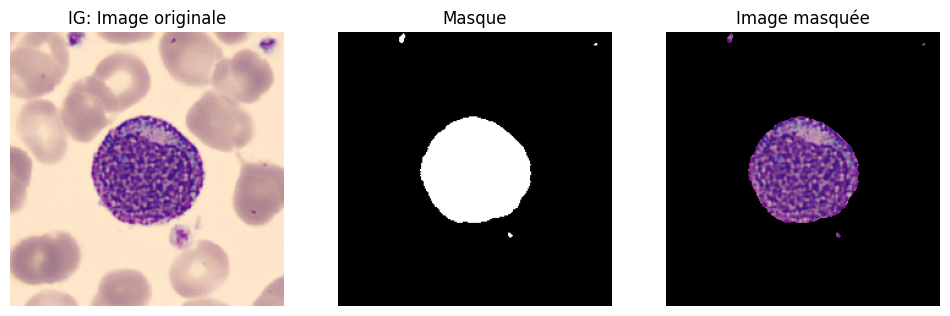

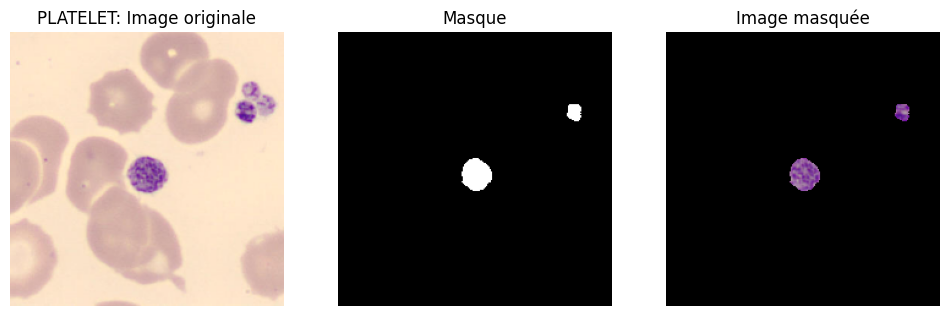

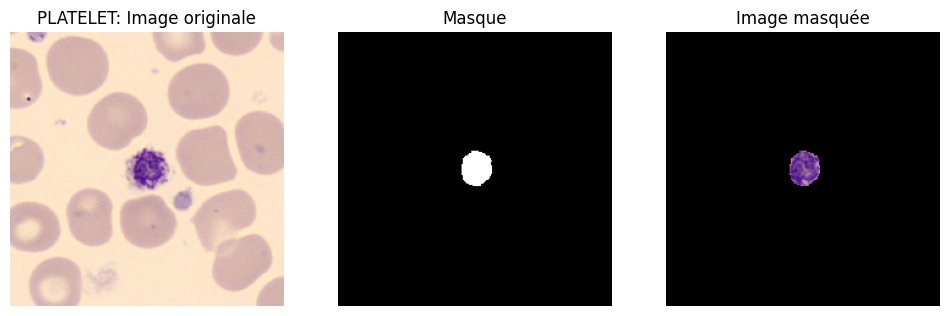

In [15]:
from tqdm import tqdm
import numpy as np
import os
import cv2
from PIL import Image
import imageio
from skimage import filters
import time

df_fusion=df_mask

# Définition d'une liste contenant les différents labels

liste_label =df_fusion.nameLabel.unique()

# Assurez-vous que le répertoire de sortie existe

for label in liste_label:
    FUSION_DF = df_fusion[df_fusion['nameLabel'] == label]
    IMAGE_PATH = FUSION_DF['filepath'].values
    MASK_PATH=FUSION_DF['maskpath'].values

    for i in tqdm(range(2)):
        # Lire l'image
        image = cv2.imread(IMAGE_PATH[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(MASK_PATH[i], cv2.IMREAD_UNCHANGED)

        desired_shape=(224,224)

        image = cv2.resize(image, desired_shape)
        mask = cv2.resize(mask, desired_shape)

        result = (image * mask[:, :, None]).astype(image.dtype)

        # Afficher les images et les histogrammes
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))

        # Afficher l'image originale
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title(label+': Image originale')
        axes[0].axis('off')

                # Afficher l'image originale
        axes[1].imshow(cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE))
        axes[1].imshow(mask*255,cmap='gray')
        axes[1].set_title('Masque')
        axes[1].axis('off')

        # Afficher l'image égalisée
        axes[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        axes[2].set_title('Image masquée')
        axes[2].axis('off')

**6. Création du dataframe 'df_fusion' des images masquées et de leur label**





In [18]:
# Trouver tous les chemins vers les fichiers qui finissent par .png
liste_fusion = glob.glob('/content/fusion/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_fusion = list(map(lambda x : [
    '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg',
    '/content/masques/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'_mask.png',
    x,
    x.split('/')[4].split('_')[0]],
    liste_fusion))

# Créer un DataFrame pandas
df_fusion = pd.DataFrame(liste_fusion, columns=['filepath','maskpath','fusionpath','nameLabel'])
df_fusion=df_fusion.replace(['SNE','BNE'],'NEUTROPHIL')
df_fusion=df_fusion.replace(['MY','MMY','PMY'],'IG')
df_fusion.sort_values('fusionpath')
df_fusion

,filepath,maskpath,fusionpath,nameLabel
0,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_674488_mask.png,/content/fusion/erythroblast/ERB_674488_fusion...,ERB
1,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_53114_mask.png,/content/fusion/erythroblast/ERB_53114_fusion.png,ERB
2,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_958159_mask.png,/content/fusion/erythroblast/ERB_958159_fusion...,ERB
3,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_692098_mask.png,/content/fusion/erythroblast/ERB_692098_fusion...,ERB
4,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_600852_mask.png,/content/fusion/erythroblast/ERB_600852_fusion...,ERB
...,...,...,...,...
17087,/content/PBC_dataset_normal_DIB/platelet/PLATE...,/content/masques/platelet/PLATELET_189530_mask...,/content/fusion/platelet/PLATELET_189530_fusio...,PLATELET
17088,/content/PBC_dataset_normal_DIB/platelet/PLATE...,/content/masques/platelet/PLATELET_127149_mask...,/content/fusion/platelet/PLATELET_127149_fusio...,PLATELET
17089,/content/PBC_dataset_normal_DIB/platelet/PLATE...,/content/masques/platelet/PLATELET_814291_mask...,/content/fusion/platelet/PLATELET_814291_fusio...,PLATELET
17090,/content/PBC_dataset_normal_DIB/platelet/PLATE...,/content/masques/platelet/PLATELET_339825_mask...,/content/fusion/platelet/PLATELET_339825_fusio...,PLATELET


In [19]:
# répartition du nombre d'images selon le label dans le dataframe df_mask
df_fusion.nameLabel.value_counts()

NEUTROPHIL    3329
EO            3117
IG            2895
PLATELET      2348
ERB           1551
MO            1420
BA            1218
LY            1214
Name: nameLabel, dtype: int64